In [1]:
import torch
import numpy as np
import subprocess
import pandas as pd
import time
import pickle
import cv2
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from config import BOX_SCALE, IM_SCALE
from dataloaders.visual_genome import VGDataLoader, VG

print('torch version', torch.__version__)
print('gitcommit', subprocess.check_output(['git', 'rev-parse', '--short', 'HEAD']).decode('ascii').strip())

torch version 1.5.0
gitcommit 9c54f73


In [2]:
data_dir = '/scratch/ssd/data/'
VG.split = 'gqa'  # set VG, GQA or VTE split here to use as a global variable
checkpoint_path = '/mnt/data/bknyazev/checkpoints/VG/62566/vgrel.pth'  # 'gqa_sggen_62566.pth'
mode = 'sgdet'
device = 'cpu'
num_gpus = 1
backbone = 'resnet50'

# should be loaded after settings some params
from lib.pytorch_misc import *
from lib.sgg_eval import BasicSceneGraphEvaluator, calculate_mR_from_evaluator_list, eval_entry
from lib.eval import val_epoch
from sgg_models.rel_model_stanford import RelModelStanford

In [7]:
# Load GQA data
train_loader, eval_loaders = VGDataLoader.splits(data_dir=data_dir,
                                                 batch_size=1,
                                                 num_workers=0,
                                                 backbone=backbone,
                                                 square_pad=False,
                                                 filter_non_overlap=mode=='sgdet',
                                                 is_cuda=False)


Loading the GQA split of Visual Genome

TRAIN DATASET
Loading GQA-train image ids...
train 67140
subj_pred_pairs, pred_obj_pairs 23472 22572
66078 images, 3455468 triplets (470129 unique triplets)
Stats: 1120047 objects (min=2.0, max=126.0, mean=17.0, std=7.8), 3392073 FG edges (min=1.0, max=1656.0, mean=51.3, std=55.4), 21897664 BG edges (331.39 avg), graph density min=0.5, max=100.0, mean=16.8, std=9.6
loading the original training split first
Loading GQA-train image ids...
train 67140
subj_pred_pairs, pred_obj_pairs 23472 22572
66078 images, 3455468 triplets (470129 unique triplets)
Stats: 1120047 objects (min=2.0, max=126.0, mean=17.0, std=7.8), 3392073 FG edges (min=1.0, max=1656.0, mean=51.3, std=55.4), 21897664 BG edges (331.39 avg), graph density min=0.5, max=100.0, mean=16.8, std=9.6

VAL DATASET (ZERO-SHOTS)
Loading GQA-val image ids...
val 5000
3025 images, 23371 triplets (18638 unique triplets)
Stats: 61192 objects (min=2.0, max=71.0, mean=20.2, std=9.0), 23055 FG edges (m

In [8]:
sgg_model = RelModelStanford(train_data=train_loader.dataset,
                             mode=mode,
                             backbone=backbone,
                             RELS_PER_IMG=1024,
                             min_size=800,
                             max_size=1333,
                             edge_model='raw_boxes')
                                                 

print("Loading EVERYTHING from %s" % checkpoint_path)
ckpt = torch.load(checkpoint_path, map_location='cpu')
success = optimistic_restore(sgg_model, ckpt['state_dict'])
sgg_model.detector.eval()
assert success, 'something wrong when loading the detector'
sgg_model.to(device)
sgg_model.eval()
sgg_model.detector.eval()
sgg_model.detector.mode = 'refinerels' if mode == 'sgdet' else 'gtbox'
print('done')


Loading COCO pretrained model maskrcnn_resnet50_fpn...

sgdet resnet50 1024 False False True
Loading EVERYTHING from /mnt/data/bknyazev/checkpoints/VG/62566/vgrel.pth
done


  0%|          | 0/10055 [00:00<?, ?it/s]


Evaluate TEST_ALLS test triplets

Evaluating SGDET...
setting refinerels mode for detector


/export/mlrg/bknyazev/anaconda3/envs/py3/lib/python3.6/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428270644/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)
/export/mlrg/bknyazev/anaconda3/envs/py3/lib/python3.6/site-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed

1001.jpg showing ground truth


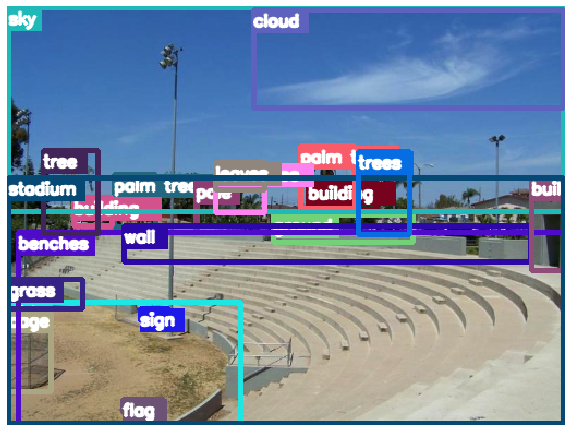

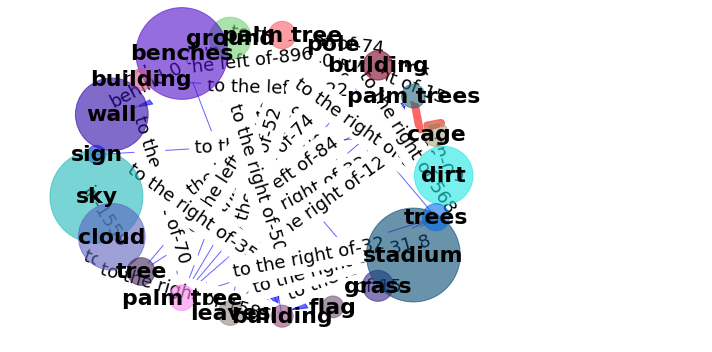

1001.jpg showing top 50 relationships


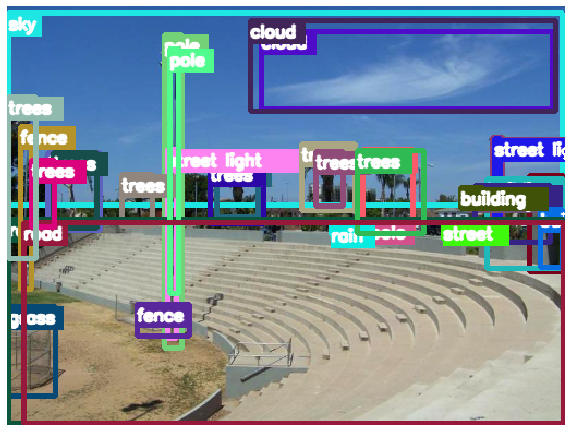

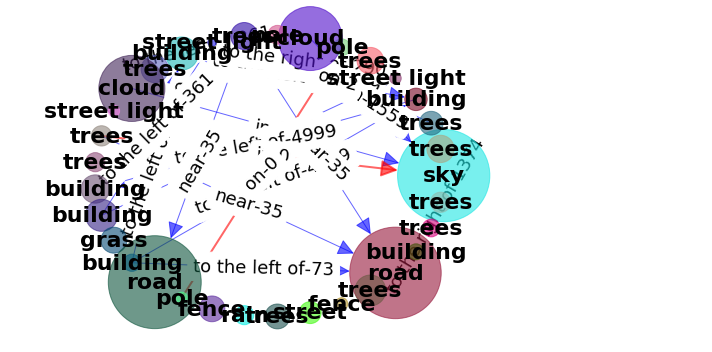

  0%|          | 1/10055 [00:04<11:11:45,  4.01s/it]

1016.jpg showing ground truth


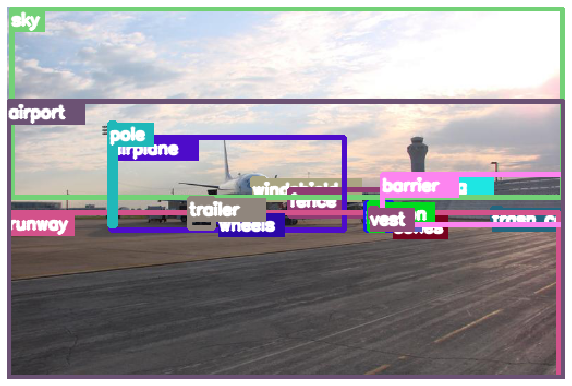

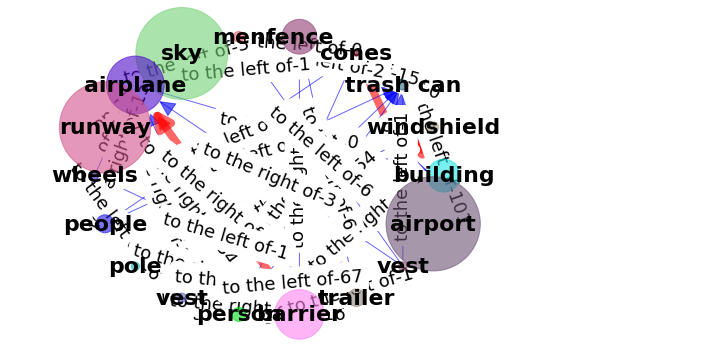

1016.jpg showing top 50 relationships


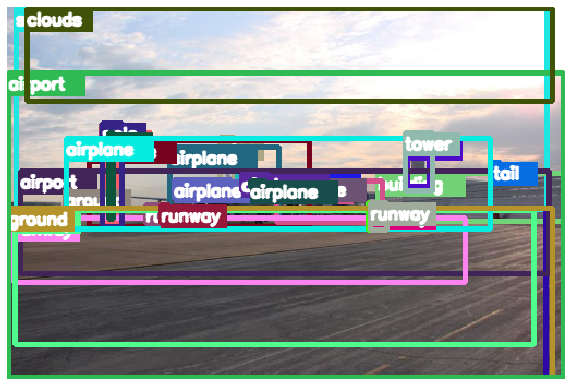

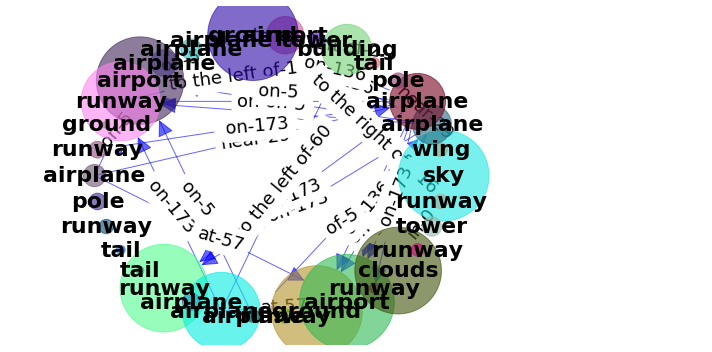

  0%|          | 2/10055 [00:08<11:11:38,  4.01s/it]

1054.jpg showing ground truth


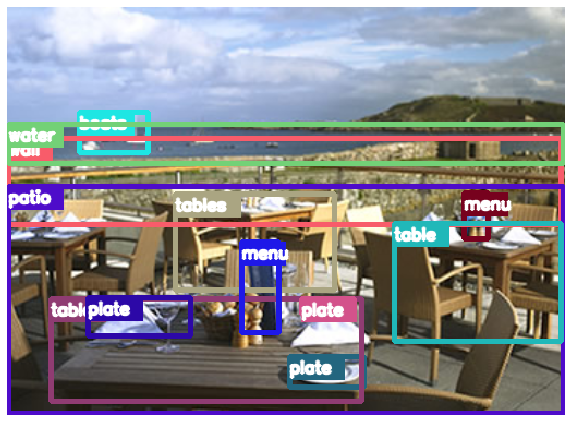

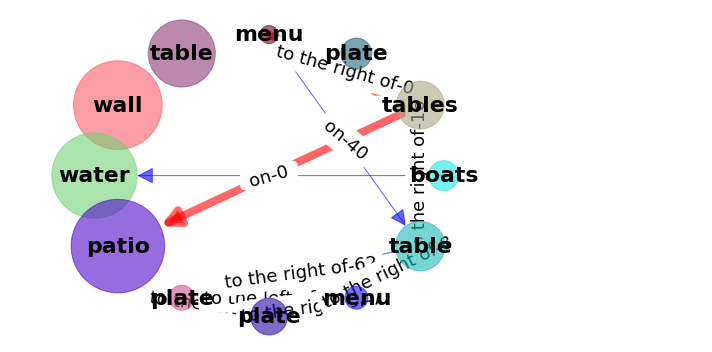

1054.jpg showing top 50 relationships


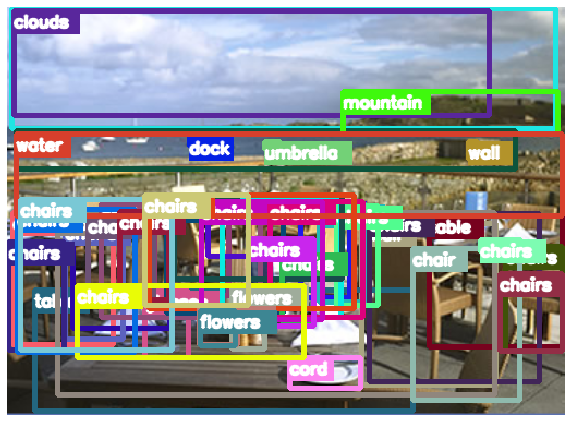

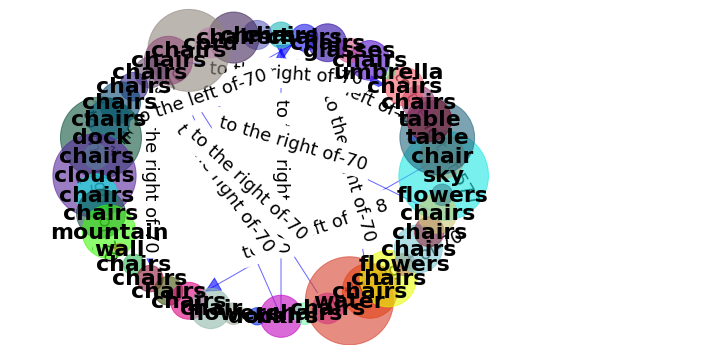

  0%|          | 3/10055 [00:12<11:52:30,  4.25s/it]

1057.jpg showing ground truth


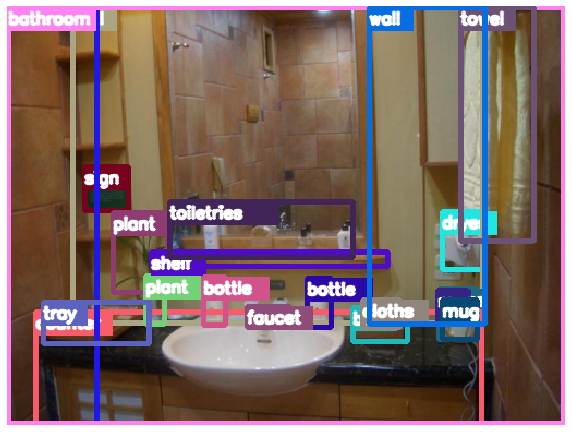

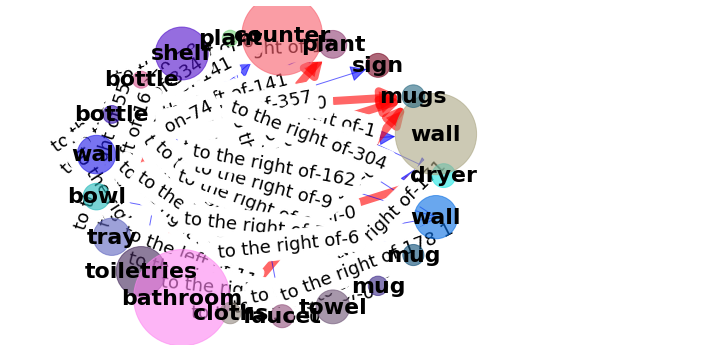

1057.jpg showing top 50 relationships


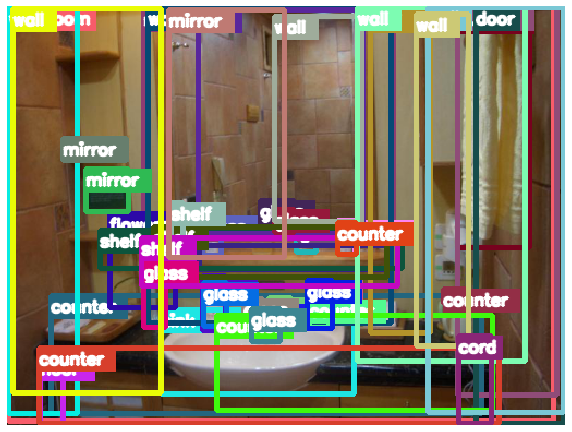

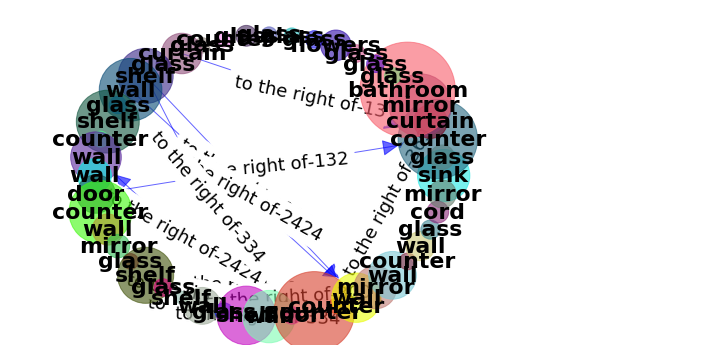

  0%|          | 4/10055 [00:17<12:29:15,  4.47s/it]

1058.jpg showing ground truth


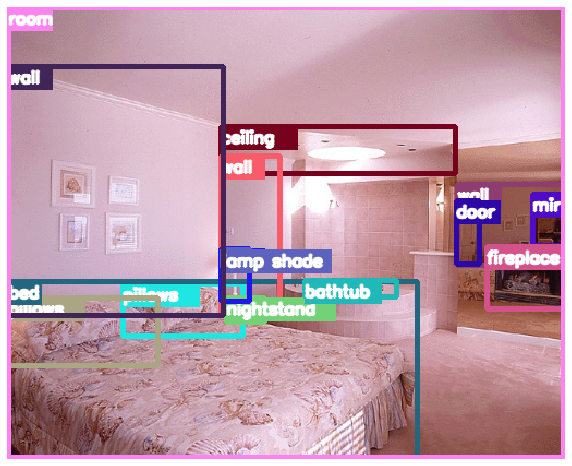

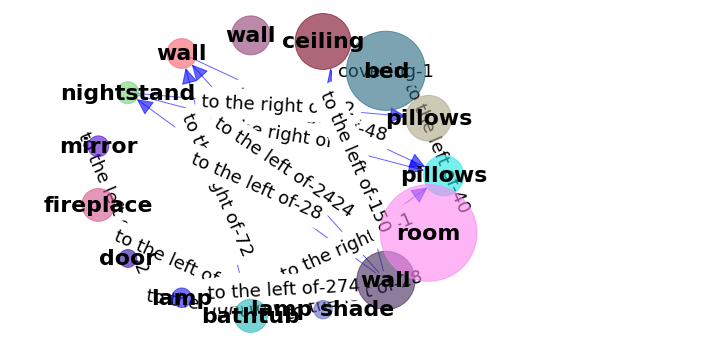

1058.jpg showing top 50 relationships


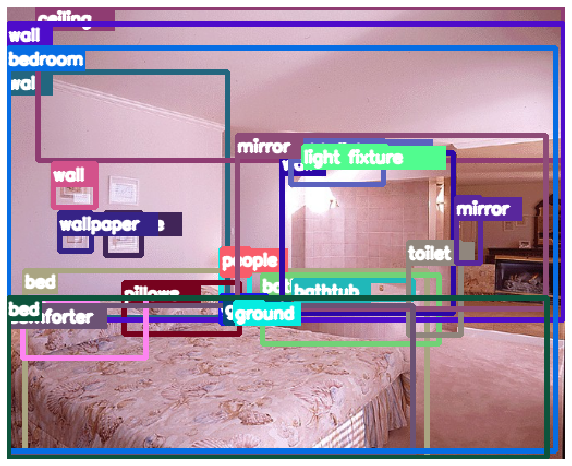

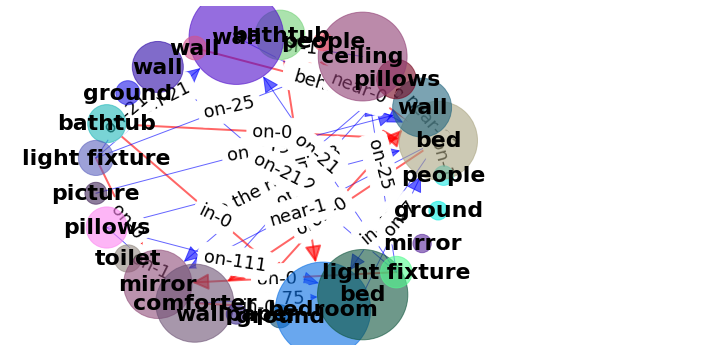

  0%|          | 5/10055 [00:21<11:45:22,  4.21s/it]

1066.jpg showing ground truth


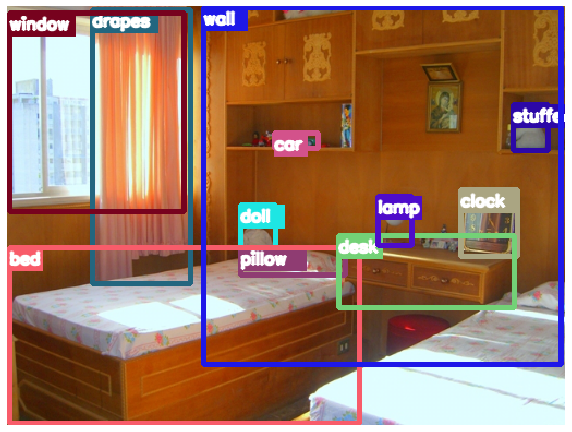

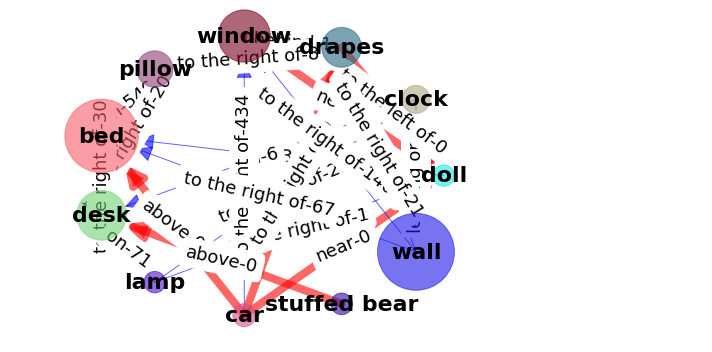

1066.jpg showing top 50 relationships


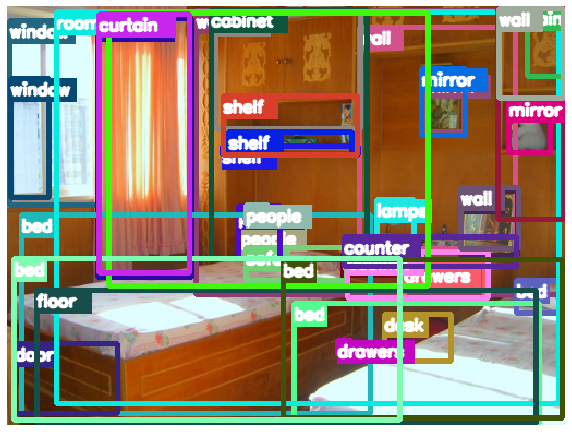

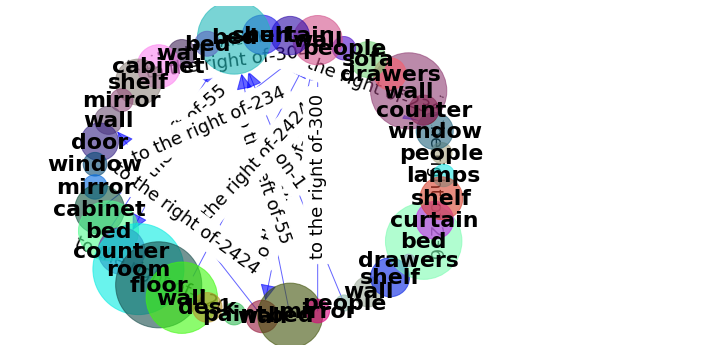

  0%|          | 7/10055 [00:27<10:04:23,  3.61s/it]

skipping a scene graph with too many objects
1074.jpg showing ground truth


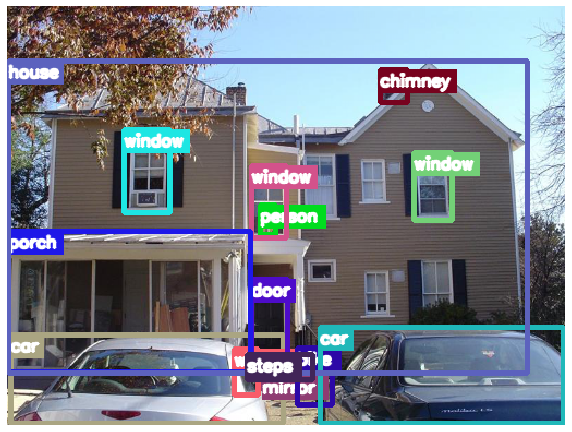

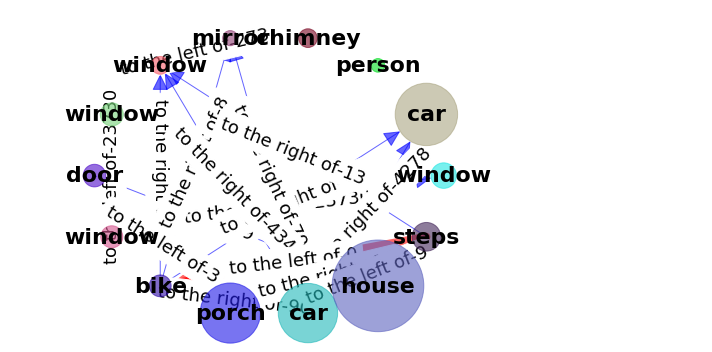

1074.jpg showing top 50 relationships


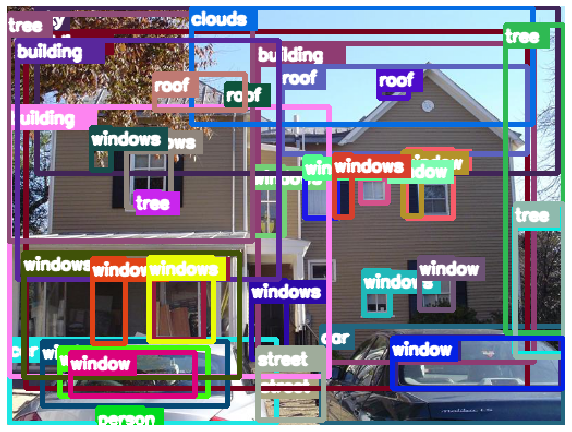

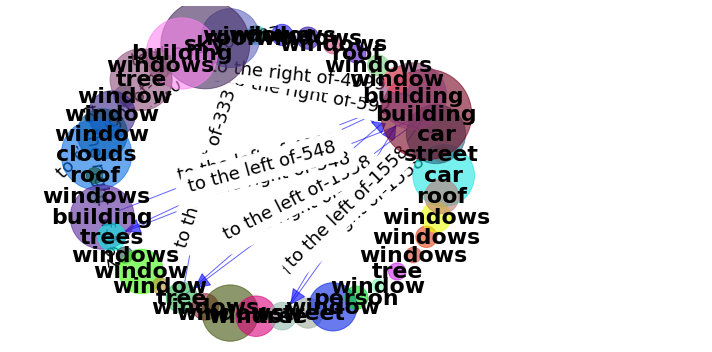

  0%|          | 8/10055 [00:31<9:54:40,  3.55s/it] 

107903.jpg showing ground truth


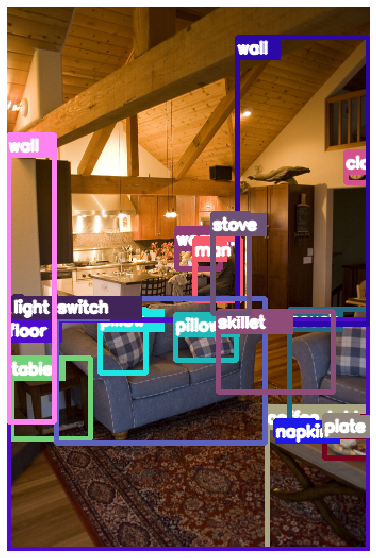

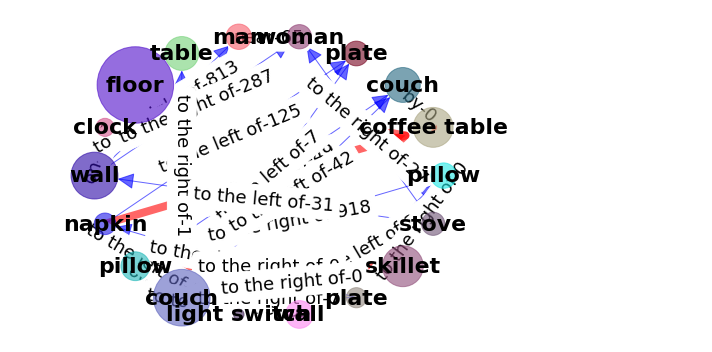

107903.jpg showing top 50 relationships


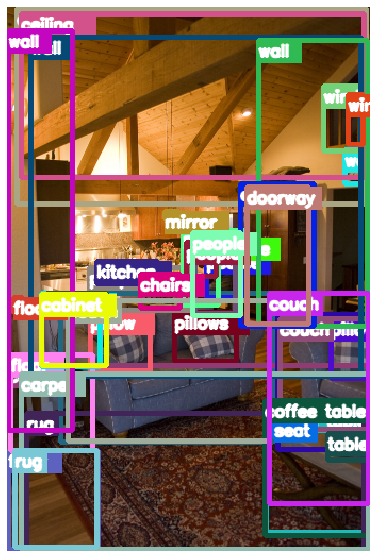

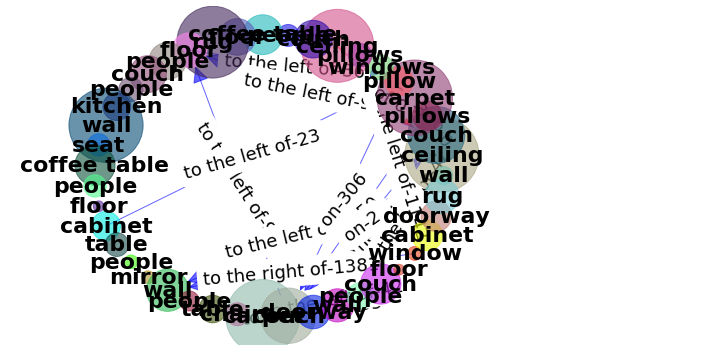

  0%|          | 9/10055 [00:35<10:19:20,  3.70s/it]

skipping a scene graph with too many objects
================sgdet(GC): 8 images ==================
R@20: 0.009607
R@50: 0.011169
R@100: 0.012732
R@200: 0.015937
R@300: 0.015937
================sgdet(NO GC): 8 images ==================
R@20: 0.012384
R@50: 0.018634
R@100: 0.025987
R@200: 0.027550
R@300: 0.033960

Triplet level evaluation (383 triplets)
Triplet level R@5: 0.0000 (normalized: 0.0000)
Triplet level R@10: 0.0000 (normalized: 0.0000)
Triplet level R@15: 0.0000 (normalized: 0.0000)
Triplet level R@20: 0.0000 (normalized: 0.0000)
Triplet level R@50: 0.0000 (normalized: 0.0000)
Triplet level mean rank: 301.0000 (normalized: 301.0000)
Triplet level median rank: 301.0000 (per class: 301.0000, normalized per class: 301.0000)



relationship:  about to hit
================sgdet(GC): 0 images ==================
R@20: nan
R@50: nan
R@100: nan
R@200: nan
R@300: nan


relationship:  above
================sgdet(GC): 2 images ==================
R@20: 0.000000
R@50: 0.000000
R@100: 0.000

/export/mlrg/bknyazev/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/export/mlrg/bknyazev/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


================sgdet(GC): 0 images ==================
R@20: nan
R@50: nan
R@100: nan
R@200: nan
R@300: nan


relationship:  parked near
================sgdet(GC): 0 images ==================
R@20: nan
R@50: nan
R@100: nan
R@200: nan
R@300: nan


relationship:  parked next to
================sgdet(GC): 0 images ==================
R@20: nan
R@50: nan
R@100: nan
R@200: nan
R@300: nan


relationship:  parked on
================sgdet(GC): 0 images ==================
R@20: nan
R@50: nan
R@100: nan
R@200: nan
R@300: nan


relationship:  perched on
================sgdet(GC): 0 images ==================
R@20: nan
R@50: nan
R@100: nan
R@200: nan
R@300: nan


relationship:  petting
================sgdet(GC): 0 images ==================
R@20: nan
R@50: nan
R@100: nan
R@200: nan
R@300: nan


relationship:  photographing
================sgdet(GC): 0 images ==================
R@20: nan
R@50: nan
R@100: nan
R@200: nan
R@300: nan


relationship:  picking up
================sgdet(GC): 0 images ========

R@20: nan
R@50: nan
R@100: nan
R@200: nan
R@300: nan


relationship:  parked at
================sgdet(NO GC): 0 images ==================
R@20: nan
R@50: nan
R@100: nan
R@200: nan
R@300: nan


relationship:  parked behind
================sgdet(NO GC): 0 images ==================
R@20: nan
R@50: nan
R@100: nan
R@200: nan
R@300: nan


relationship:  parked beside
================sgdet(NO GC): 0 images ==================
R@20: nan
R@50: nan
R@100: nan
R@200: nan
R@300: nan


relationship:  parked by
================sgdet(NO GC): 0 images ==================
R@20: nan
R@50: nan
R@100: nan
R@200: nan
R@300: nan


relationship:  parked in
================sgdet(NO GC): 0 images ==================
R@20: nan
R@50: nan
R@100: nan
R@200: nan
R@300: nan


relationship:  parked in front of
================sgdet(NO GC): 0 images ==================
R@20: nan
R@50: nan
R@100: nan
R@200: nan
R@300: nan


relationship:  parked near
================sgdet(NO GC): 0 images ==================
R@20: nan
R@50:

{'sgdet': []}

In [9]:
# Let's visualize ground truth and predictions for a bunch of test images
eval_split = 'test_alls'
val_epoch(mode, sgg_model, 
          eval_loaders[eval_split], 
          eval_split,
          train_loader.dataset.triplet_counts,
          train_loader.dataset.triplet2str,
          is_test=True, 
          vis=True, n_batches=10, max_obj=30, max_rels=50, 
          train=train_loader.dataset, test_zs=eval_loaders['test_zs'].dataset)